In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score
from sklearn.preprocessing import PowerTransformer
yj = PowerTransformer(method='yeo-johnson')


def yj_transform_train_test(df_train_before, df_test_before):
    yj_model = yj.fit(df_train_before.drop(['id', 'label'], axis=1))
    
    df_train_after = yj_transform_by_model(yj_model, df_train_before)
    df_test_after = yj_transform_by_model(yj_model, df_test_before)
    
    return df_train_after, df_test_after

def yj_transform_by_model(yj_model, df_data_before):
    list_pid = list(df_data_before['id']).copy()
    list_label = list(df_data_before['label']).copy()
    
    df_data_before = df_data_before.drop(['id', 'label'], axis=1)
    
    X_data_after = yj_model.transform(df_data_before)
    df_data_after = pd.DataFrame(X_data_after)
    df_data_after.columns = df_data_before.columns
    df_data_after['id'] = list_pid
    df_data_after['label'] = list_label
    
    return df_data_after

def get_feature_and_label(df_data, var_label):
    X = df_data.drop([var_label, 'id'], axis = 1)
    y = df_data[var_label]
    
    return X, y

def get_roc_curve(y_pred_prob, y):
    fpr, tpr, _ = roc_curve(y, y_pred_prob[:,1])
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic xgb')
    plt.legend(loc="lower right")
    plt.show()
    
BASE_PATH = './data/'
PATH_feature_all = BASE_PATH + 'thyroid_feature_all.csv'
PATH_feature_test = BASE_PATH + 'thyroid_feature_198.csv'

# Logistic regression classifier

In [2]:
# Load malignancy feature data
df_feature_all = pd.read_csv(PATH_feature_all)
df_feature_test = pd.read_csv(PATH_feature_test)
id_train = set(df_feature_all['id']) - set(df_feature_test['id'])
id_test = list(df_feature_test['id'])
df_feature_train = pd.DataFrame({'id': list(id_train)})
df_feature_train = df_feature_train.merge(df_feature_all, how='left')

df_feature_train.head()

,id,label,aspect_ratio,cystic_count,otsu_threshold,echo,composition,calci_count,mirco_calci_count,micro_calci_length_min,micro_calci_length_mean
0,P_TT-1234.png,1,1.197178,3,64.191756,0.860759,0.30,1,1,0.390625,0.390625
1,P_TT-4170.png,1,0.678015,2,54.500000,0.430769,0.41,5,4,1.187785,1.444387
2,P_TT-4235.png,0,1.202270,2,41.105422,0.898305,0.58,0,0,NaN,NaN
3,P_TT-1557.png,0,1.403262,1,48.508630,0.925000,0.31,0,0,NaN,NaN
4,P_TT-2996.png,1,0.663796,2,60.748915,0.788235,0.24,1,0,NaN,NaN


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5419d1b430>,
      dtype=object)

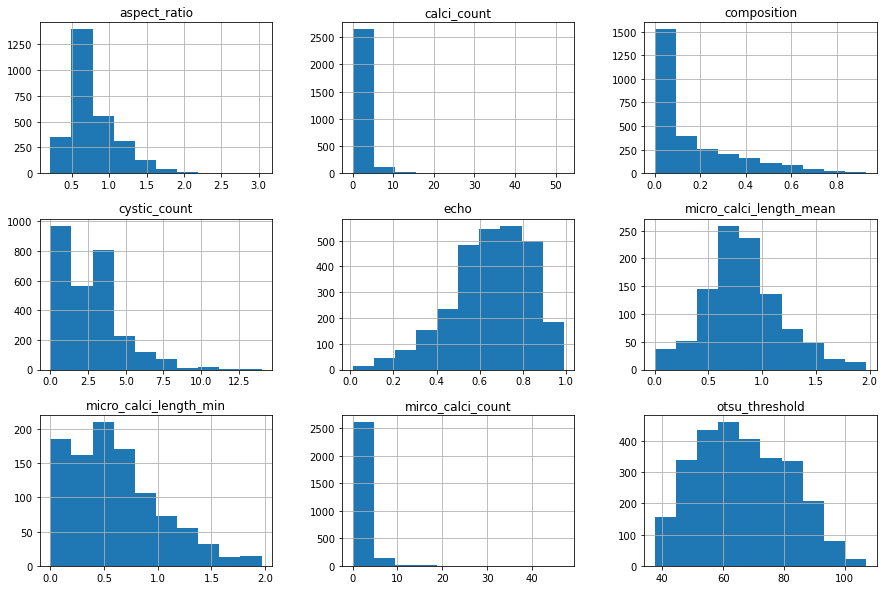

In [3]:
# Check distribution
df_feature_train.drop(['label'], axis=1).hist(figsize=(15,10))

In [4]:
# apply power transform
df_feature_train, df_feature_test = yj_transform_train_test(df_feature_train, df_feature_test)

var_label = 'label'
X_train, y_train = get_feature_and_label(df_feature_train, var_label)
X_test, y_test = get_feature_and_label(df_feature_test, var_label)

print('label imbalance: ', sum(y_train==1)/sum(y_train==0))

label imbalance:  0.5496394897393233


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5418e3a4f0>,
      dtype=object)

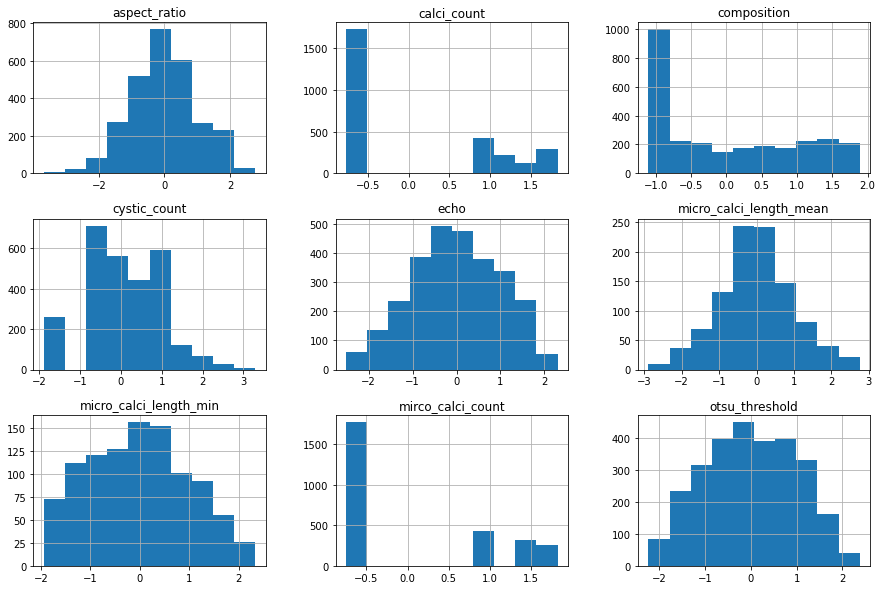

In [5]:
# Check distribution
X_train.hist(figsize=(15,10))

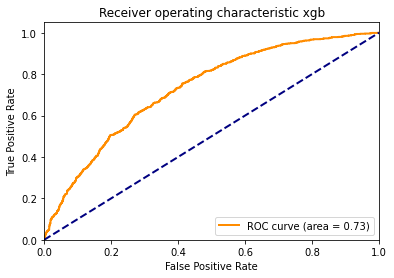

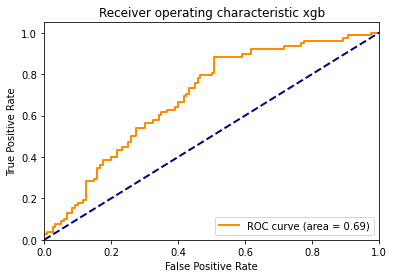

In [6]:
X_train_impute = X_train.fillna(0)
X_test_impute = X_test.fillna(0)

classifier_lr = LogisticRegression(class_weight=1.82)
classifier_lr.fit(X_train_impute, y_train)

y_train_pred_prob = classifier_lr.predict_proba(X_train_impute)
y_test_pred_prob = classifier_lr.predict_proba(X_test_impute)

get_roc_curve(y_train_pred_prob, y_train)
get_roc_curve(y_test_pred_prob, y_test)

# XGBoost classifier

In [7]:
# Load malignancy feature data
df_feature_all = pd.read_csv(PATH_feature_all)
df_feature_test = pd.read_csv(PATH_feature_test)
id_train = set(df_feature_all['id']) - set(df_feature_test['id'])
id_test = list(df_feature_test['id'])
df_feature_train = pd.DataFrame({'id': list(id_train)})
df_feature_train = df_feature_train.merge(df_feature_all, how='left')

# Train-validation split
df_feature_train, df_feature_val = train_test_split(df_feature_train, test_size=0.2)

var_label = 'label'
X_train, y_train = get_feature_and_label(df_feature_train, var_label)
X_val, y_val = get_feature_and_label(df_feature_val, var_label)
X_test, y_test = get_feature_and_label(df_feature_test, var_label)

print('label imbalance: ', sum(y_train==1)/sum(y_train==0))

label imbalance:  0.5531619179986101


In [8]:
# [ToDo]: xgboost with early stopping
eval_set  = [(X_train,y_train), (X_val,y_val)]
classifier_xgb = XGBClassifier(
    n_estimators=5000,
    scale_pos_weight = 1.82,
    eta = 0.1,  
    max_depth = 2,
).fit(
    X_train, 
    y_train, 
    eval_set=eval_set,
    eval_metric="auc", 
    early_stopping_rounds=10, 
    verbose=1
)

[0]	validation_0-auc:0.68625	validation_1-auc:0.64865
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.68753	validation_1-auc:0.65052
[2]	validation_0-auc:0.71758	validation_1-auc:0.69086
[3]	validation_0-auc:0.72255	validation_1-auc:0.69050
[4]	validation_0-auc:0.73008	validation_1-auc:0.70804
[5]	validation_0-auc:0.73616	validation_1-auc:0.71378
[6]	validation_0-auc:0.73863	validation_1-auc:0.71861
[7]	validation_0-auc:0.73768	validation_1-auc:0.71720
[8]	validation_0-auc:0.73949	validation_1-auc:0.71997
[9]	validation_0-auc:0.74624	validation_1-auc:0.72206
[10]	validation_0-auc:0.74622	validation_1-auc:0.72122
[11]	validation_0-auc:0.74834	validation_1-auc:0.72039
[12]	validation_0-auc:0.74975	validation_1-auc:0.72314
[13]	validation_0-auc:0.75007	validation_1-auc:0.72458
[14]	validation_0-auc:0.75061	validation_1-auc:0.72425
[15]	validation_0-auc:0.7511

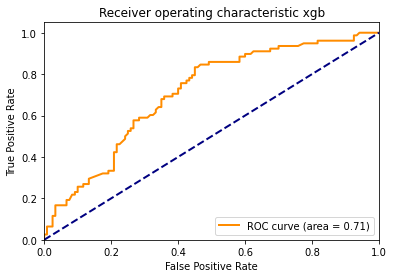

In [9]:
y_test_pred_prob = classifier_xgb.predict_proba(X_test, ntree_limit=classifier_xgb.best_ntree_limit)
get_roc_curve(y_test_pred_prob, y_test)

# Model ensemble

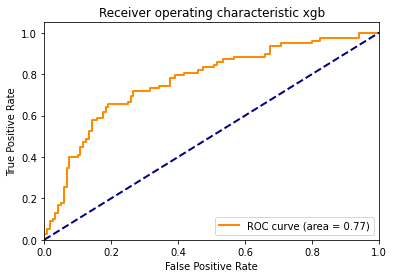

In [11]:
import numpy as np
df_resnet_prob = pd.read_csv('./data/resnet_output_198.csv')

df_xgboost_prob = pd.DataFrame({
    'id': df_feature_test['id'],
    'label': df_feature_test['label'],
    'xgboost_prob': y_test_pred_prob[:,0]
})

df_ensemble = df_xgboost_prob.merge(df_resnet_prob)

prob = df_ensemble['xgboost_prob']*0.5 + df_ensemble['resnet_proba']*0.5
y_test_pred_prob = np.array(list(zip(prob, 1-prob)))
y_test = df_ensemble['label']

get_roc_curve(y_test_pred_prob, y_test)